# Classification

## Objectives

*   Fit and evaluate a classification model to predict if a prospect will churn or not.


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* instructions on which variables to use for data cleaning and feature engineering. They are found on its respectives notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

---

# Load Data For Modelling

In [ ]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv")
      .drop(labels=['tenure','customerID','TotalCharges'],axis=1)  
                    # target variable for regressor, remove from classifier  
                    # drop other variables we will not need for this project
  )

df.info()

We know already in upfront that **Train Set Target (Churn) is imbalanced**
  * We will apply SMOTE technique to handle that. That was covered in Develop & Deploy an AI System - Target Imbalance
  * Therefore, we will produce 2 ML Pipelines:
    * One for Data Cleaning and Feature Engineering
    * Another for Feature Scaling, Feature Selection and Modeling
  * The pipelines will be used to train the pipeline, to test the pipeline and to predict on live data

---

# ML Pipeline with all available data: Sklearn

## ML pipeline for Data Cleaning and Feature Engineering

* Load Estimators for pipelines

In [ ]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


* Data Cleaninig And Feature Engineering

In [ ]:
def PipelineDataCleaningAndFeatureEngineering():
  pipeline_base = Pipeline(
      [
      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = [ 'gender', 'Partner', 'Dependents', 'PhoneService',
                                                               'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                               'OnlineBackup','DeviceProtection', 'TechSupport', 
                                                               'StreamingTV', 'StreamingMovies','Contract', 
                                                               'PaperlessBilling', 'PaymentMethod'])
      ),
       
      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman",
                                                           threshold=0.6, selection_method="variance")
      ),
       
    ]
  )

  return pipeline_base

## ML Pipeline for Modelling and Hyperparameter Optimization

Pipeline Optmization
* Feature Scaling
* Feature Selection
* Model

In [ ]:
def PipelineClfSMOTE(model):
  pipeline_base = Pipeline(
      [
       ("scaler",StandardScaler() ),
       ("feat_selection",SelectFromModel(model) ),
       ("model",model ),
    ]
  )

  return pipeline_base

Custom Class for hyperparameter Optimization and search best model

In [ ]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model=  PipelineClfSMOTE(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, )
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


## Split Train and Test Set

* Quick recap in our dataset

In [ ]:
print(df.shape)
df.head(3)

* Split Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['Churn'],axis=1),
                                    df['Churn'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## SMOTE: deal with Target Imbalance

Fit DataCleaning And FeatureEngineering Pipeline
  * It is used to process train data, so SMOTE can be applied before training the model

In [ ]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Let's check how it looks like

In [ ]:
X_train.head(3)

Check Train Set Target distribution

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()
print("\n* Class proportion on Train Set\n", y_train.value_counts(normalize=True).to_frame().round(2))
print("\n* Class proportion on Test Set\n", y_test.value_counts(normalize=True).to_frame().round(2))

Use SMOTE to balance Train Set target

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Check Train Set Target distribution after SMOTE

In [ ]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()
print("\n* Class proportion on Train Set\n", y_train.value_counts(normalize=True).to_frame().round(2))
print("\n* Class proportion on Test Set\n",y_test.value_counts(normalize=True).to_frame().round(2))

## Grid Search CV - Sklearn

### Use standard hyper parameters to find most suitable model

Define models and parameters, for Quick Search

In [41]:
models_quick_search = {
    "XGBClassifier":XGBClassifier(random_state=0),
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier":RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier":AdaBoostClassifier(random_state=0),
    "XGBClassifier":XGBClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
    "XGBClassifier":{},
    "LogisticRegression":{},
}

Quick GridSearch CV - Binary Classifier

In [42]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [43]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,XGBClassifier,0.822249,0.865718,0.885127,0.0237706
3,GradientBoostingClassifier,0.741233,0.822651,0.865617,0.0477005
5,AdaBoostClassifier,0.738499,0.796511,0.83414,0.0364747
6,LogisticRegression,0.650544,0.738688,0.794438,0.0537167
2,RandomForestClassifier,0.617896,0.738206,0.825666,0.0842078
4,ExtraTreesClassifier,0.568319,0.723443,0.824455,0.110215
1,DecisionTreeClassifier,0.405079,0.624483,0.757869,0.150788


Check the best model

In [44]:
best_model = grid_search_summary.iloc[0,0]
best_model

'XGBClassifier'

### Do extensive search on most suitable model to find best hyperparameter configuration

Define model and parameters, for Extensive Search

In [45]:
models_search = {
    "XGBClassifier":XGBClassifier(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "XGBClassifier":{
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV - Binary Classifier

In [46]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Check results

In [47]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
3,XGBClassifier,0.882709,0.9233,0.945586,0.0249355,0.01,3
6,XGBClassifier,0.882709,0.9233,0.945586,0.0249355,0.001,3
0,XGBClassifier,0.822249,0.865718,0.885127,0.0237706,0.1,3
1,XGBClassifier,0.822249,0.865718,0.885127,0.0237706,0.1,10
2,XGBClassifier,0.822249,0.865718,0.885127,0.0237706,0.1,None
4,XGBClassifier,0.822249,0.865718,0.885127,0.0237706,0.01,10
5,XGBClassifier,0.822249,0.865718,0.885127,0.0237706,0.01,None
7,XGBClassifier,0.822249,0.865718,0.885127,0.0237706,0.001,10
8,XGBClassifier,0.822249,0.865718,0.885127,0.0237706,0.001,None


Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model
* We are saving this content for later

In [48]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.01, 'model__max_depth': 3}

Define the best clf pipeline

In [49]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         importance_type='gain',
                                                         interaction_constraints=None,
                                                         learning_rate=None,
                                                         max_delta_step=None,
                                                         max_depth=None

## Assess feature importance

* With the current model, we can assess with `.features_importances_`

* These are the 2 most important features in descending order. The model was trained on them: 
['Contract', 'InternetService']


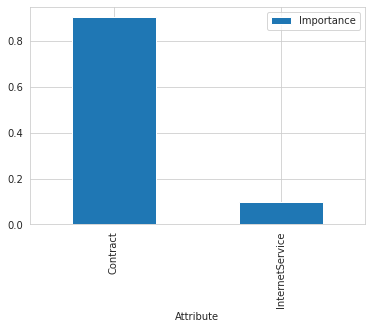

In [50]:
best_features = X_train.columns[pipeline_clf['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Attribute': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
.sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Attribute'].to_list() # re-assign best_features order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Attribute'].to_list()}")

df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.show()

We will save the most important features to fit a new pipeline

In [51]:
best_features_with_all_variables = best_features
best_features_with_all_variables

['Contract', 'InternetService']

## Evaluate Classifier on Train and Test Sets

 Custom Function

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X,y,pipeline,label_map):

  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction),"\n")


def clf_performance(X_train,y_train,X_test,y_test,pipeline,label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

Evaluation
 * We cross check with metrics defined at ML business case

In [57]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            2361          317
Prediction Churn               1772         3816


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.88      0.57      0.69      4133
           1       0.68      0.92      0.79      4133

    accuracy                           0.75      8266
   macro avg       0.78      0.75      0.74      8266
weighted avg       0.78      0.75      0.74      8266
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn             593           54
Prediction Churn                448          314


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.92      0.57      0.70      1041
           1       0.41      0.85      0.56       368

    accuracy                           0.64      

# Refit pipeline with best features

## New ML Pipeline

In theory, a pipeline fitted **using only the most important features** has to give the same result as the one fitted with **all variables and feature selection**

* However in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE()
* We should remember that the Train Set with all features is different from the Train Set with the best features we found (since it has less variables)
* Therefore the Train Set after applying the SMOE() will be slightly different, which means the performance will be slightly different. We should expect that. What we can't expect is to have a big difference 

This new pipeline should consider only the set of most important features

In [60]:
best_features_with_all_variables

['Contract', 'InternetService']

## Rewrite ML pipeline for Data Cleaning and Feature Engineering

New Pipeline for DataCleaning And FeatureEngineering

In [61]:
def PipelineDataCleaningAndFeatureEngineering():
  pipeline_base = Pipeline(
      [

      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary',
                                                  variables = [ 'InternetService', 'Contract']
                                                  )
      ),
       
    ]
  )

  return pipeline_base

## Rewrite ML Pipeline for Modelling

Function for Pipeline optmization

In [62]:
# Pipeline Optmization: Feature Scaling, and Model
# there is no feature selection
def PipelineClfSMOTE(model):
  pipeline_base = Pipeline(
      [
       ("scaler",StandardScaler()),
       # no feature selection here!!!
       ("model",model ),
    ]
  )

  return pipeline_base


## Split Train Test Set, considering only with best features

* Split Train and Test Sets

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['Churn'],axis=1),
                                    df['Churn'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5634, 17) (5634,) (1409, 17) (1409,)


We filter only the most important variables

In [64]:
X_train = X_train.filter(best_features_with_all_variables)
X_test = X_test.filter(best_features_with_all_variables)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5634, 2) (5634,) (1409, 2) (1409,)


In [65]:
X_train.head(3)

,Contract,InternetService
2920,Two year,DSL
2966,Month-to-month,DSL
6099,Two year,No


## SMOTE: deal with Target Imbalance

* Fit DataCleaning And FeatureEngineering Pipeline
  * It is used to process train data, so SMOTE can be applied before training the model

In [66]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5634, 2) (5634,) (1409, 2) (1409,)


* Check Train Set Target distribution

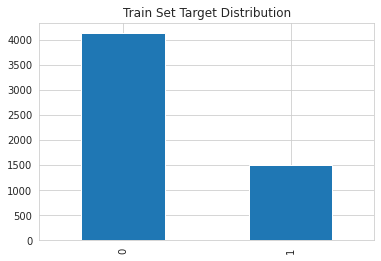


* Class proportion on Train Set
    Churn
0   0.73
1   0.27

* Class proportion on Test Set
    Churn
0   0.74
1   0.26


In [67]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()
print("\n* Class proportion on Train Set\n", y_train.value_counts(normalize=True).to_frame().round(2))
print("\n* Class proportion on Test Set\n",y_test.value_counts(normalize=True).to_frame().round(2))

* Use SMOTE to balance Train Set target

In [68]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8266, 2) (8266,) (1409, 2) (1409,)


* Check Train Set Target distribution after SMOTE

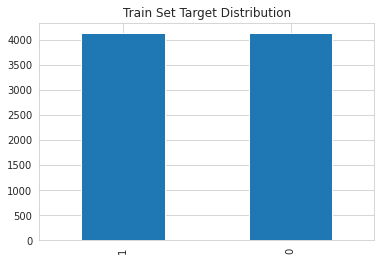


* Class proportion on Train Set
    Churn
1    0.5
0    0.5

* Class proportion on Test Set
    Churn
0   0.74
1   0.26


In [69]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()
print("\n* Class proportion on Train Set\n", y_train.value_counts(normalize=True).to_frame().round(2))
print("\n* Class proportion on Test Set\n",y_test.value_counts(normalize=True).to_frame().round(2))

## Grid Search CV: Sklearn

* Using most suitable model from last section and it best hyper parameter configuration

We are using the same model fomr the last GridCV search

In [70]:
models_search

{'XGBClassifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=0, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)}

And the best parameters from the last GridCV search 

In [71]:
best_parameters

{'model__learning_rate': 0.01, 'model__max_depth': 3}

You will need to type in manually, since the hyperparameter values has to be a list. The previous dictonary is not in this format

In [72]:
params_search = {'XGBClassifier':  {
    'model__learning_rate': [0.01],   # the value should be in []
    'model__max_depth': [3]}, # the value should be in []
}
params_search

{'XGBClassifier': {'model__learning_rate': [0.01], 'model__max_depth': [3]}}

GridSearch CV

In [73]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring =  make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [74]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
0,XGBClassifier,0.882709,0.897169,0.905683,0.00928089,0.01,3


Check the best model

In [75]:
best_model = grid_search_summary.iloc[0,0]
best_model

'XGBClassifier'

Parameters for best model

In [76]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.01, 'model__max_depth': 3}

Define the best clf pipeline

In [77]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

## Assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['Contract', 'InternetService']


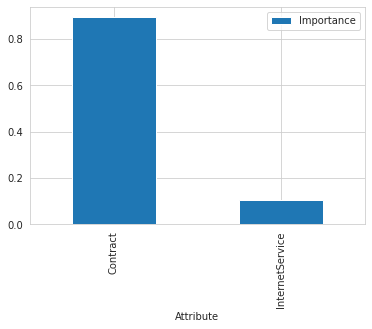

In [78]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': pipeline_clf['model'].feature_importances_})
.sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Attribute'].to_list()}")

df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.show()

## Evaluate Classifier on Train and Test Sets

In [79]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            2361          425
Prediction Churn               1772         3708


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.85      0.57      0.68      4133
           1       0.68      0.90      0.77      4133

    accuracy                           0.73      8266
   macro avg       0.76      0.73      0.73      8266
weighted avg       0.76      0.73      0.73      8266
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn             593           54
Prediction Churn                448          314


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.92      0.57      0.70      1041
           1       0.41      0.85      0.56       368

    accuracy                           0.64      

# Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_churn/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

* Pay attention that the Train set and Test set are not in the same format as when it was splitted
* That is due to the fact we needed to apply SMOTE to the Train Set

## Train Set

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was appllied

In [ ]:
print(X_train.shape)
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjuntion to predict Live Data
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed



Pipeline responsible for Data Cleaning and Feature Engineering


In [ ]:
pipeline_data_cleaning_feat_eng

In [ ]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

* Pipeline responsible for Feature Scaling, and Model

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

## Feature Importance plot

In [ ]:
df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar', x='Attribute', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---

## **Push** generated/new files from this Session to GitHub repo

* Git status

In [ ]:
! git status

* Git commit

In [ ]:
CommitMsg = "added-files-predict-churn"
! git add .
! git commit -m {CommitMsg}

* Git Push

In [ ]:
! git push origin main